In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

plt.ion()
% matplotlib inline

In [19]:
# data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data/'
images_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(images_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(images_datasets[x]) for x in ['train', 'val']}
classes_names = images_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


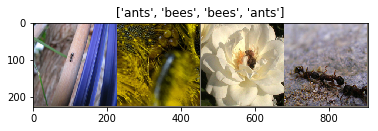

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_names[x] for x in classes])

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """train model
    Args:
        model: model.
        criterion: loss function.
        optimizer: optimizer.
        scheduler: an LR scheduler object from troch.optim.lr_scheduler.
    """
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if(phase == 'train'):
                scheduler.step()
                model.train() # set model to training mode
            else:
                model.eval()  # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dset_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    if(phase == 'train'):
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if(phase == 'val' and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val ACC: {:4F}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [37]:
# visualizing the model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if(images_so_far == num_images):
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

## Finetuning the convnet

In [33]:
# finetuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5936 Acc: 0.6967
val Loss: 0.1996 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.6136 Acc: 0.7869
val Loss: 0.7454 Acc: 0.7582

Epoch 2/24
----------
train Loss: 0.7416 Acc: 0.7377
val Loss: 0.2710 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.6185 Acc: 0.7746
val Loss: 0.2975 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4956 Acc: 0.7992
val Loss: 0.2037 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4994 Acc: 0.8279
val Loss: 0.2201 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3527 Acc: 0.8484
val Loss: 0.2715 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3791 Acc: 0.8566
val Loss: 0.2805 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2983 Acc: 0.8893
val Loss: 0.2606 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2830 Acc: 0.9057
val Loss: 0.2925 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3455 Acc: 0.8361
val Loss: 0.2425 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2371 Acc: 0.9016
val Loss: 0.2360 Acc: 0.9346

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


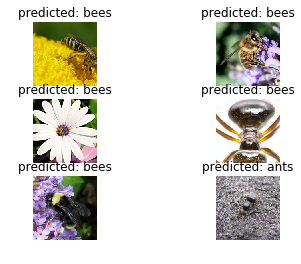

In [39]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
通过设置`requires_grad == False`冻结所有网络参数，除了最后一层，使其在反向传播时不会更新。

In [42]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5974 Acc: 0.6434
val Loss: 0.2582 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5812 Acc: 0.7377
val Loss: 0.3496 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4547 Acc: 0.7910
val Loss: 0.1730 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4589 Acc: 0.8115
val Loss: 0.1876 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3793 Acc: 0.8443
val Loss: 0.1682 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4910 Acc: 0.7910
val Loss: 0.1802 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5793 Acc: 0.7541
val Loss: 0.1876 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3776 Acc: 0.8648
val Loss: 0.2276 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4242 Acc: 0.8074
val Loss: 0.1967 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4200 Acc: 0.8279
val Loss: 0.1876 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3736 Acc: 0.8484
val Loss: 0.1901 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3418 Acc: 0.8525
val Loss: 0.1901 Acc: 0.9412

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


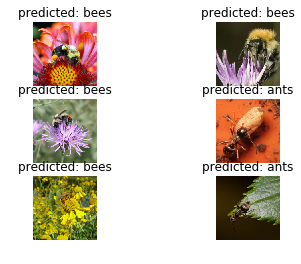

In [43]:
visualize_model(model_conv)